In [1]:
# Update scikit-learn to lastest version in Google Colab
!pip install --upgrade scikit-learn

     |████████████████████████████████| 6.8MB 11.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
### This is a GPU implementation for the HQC classifier using Scikit-learn's methods, but with PyTorch as the backend. ###

In [ ]:
# I have implemented the code below in such a way that you would only need to input X and y as numpy arrays and the
# output y_hat would also be a numpy array (rather than PyTorch tensors). This would make it easier to use the package
# below with minimal knowledge of PyTorch tensors.

# Take note of the parameter n_splits, where the implementation of n_splits now is different to the one in the CPU case.
# Please read the description of n_splits below.

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import check_classification_targets
import torch
from torch.nn.functional import normalize
from scipy import linalg

class PGMHQC_gpu_dtype(BaseEstimator, ClassifierMixin):
    """The Pretty Good Measurement (PGM) - Helstrom Quantum Centroid (HQC) classifier is a 
    quantum-inspired supervised classification approach for data with multiple classes.
                         
    Parameters
    ----------
    rescale : int or float, default = 1
        The dataset rescaling factor. A parameter used for rescaling the dataset. 
    encoding : str, default = 'amplit'
        The encoding method used to encode vectors into quantum densities. Possible values:
        'amplit', 'stereo'. 'amplit' means using the amplitude encoding method. 'stereo' means 
        using the inverse of the standard stereographic projection encoding method. Default set 
        to 'amplit'.
    n_copies : int, default = 1
        The number of copies to take for each quantum density. This is equivalent to taking 
        the n-fold Kronecker tensor product for each quantum density.
    measure : str, default = 'pgm'
        The measurement used to distinguish between quantum states. Possible values: 'pgm', 
        'hels'. The value 'pgm' stands for "Pretty Good Measurement", 'hels' stands for 
        "Helstrom measurement" (applicable only for binary classification). Default set to 
        'pgm'. 
    class_wgt : str, default = None        
        Applicable only when "Helstrom measurement" is selected. This is the class weights 
        assigned to the Quantum Helstrom observable terms. Possible values: 'equi', 'weighted', 
        'custom', None. 'equi' means assigning equal weights of 1/2 (equiprobable) to the two terms in 
        the Quantum Helstrom observable. 'weighted' means assigning weights equal to the 
        proportion of the number of rows in each class to the two terms in the Quantum Helstrom 
        observable. 'custom' means selecting your own custom weights. When using "Pretty Good Measurement", 
        specify class_wgt = None. Default set to None.  
    custom_weight : float, default = None
        Weight values given to class with index 0 when class_wgt = 'custom' is selected. Default set to None.
    n_splits : int, default = 1
        The number of subset splits performed on the input dataset row-wise and on the number 
        of eigenvalues/eigenvectors of the Quantum Helstrom observable for optimal speed 
        performance. If 1 is given, no splits are performed. For optimal speed, recommend 
        using small values as close to 1 as possible. If memory blow-out occurs, increase 
        n_splits.
    dtype : torch.float32 or torch.float64, default = torch.float64
        The float datatype used for the elements in the Pytorch tensor dataset. Datatype has to
        be of float to ensure calculations are done in float rather than integer. To achieve
        higher n_copies without memory blow-out issues, reduce float precision, which may or may   
        not affect accuracy in a significant way.
    
    Attributes
    ----------
    classes_ : ndarray, shape (n_classes,)
        Sorted binary classes. Stored in CPU.
    qcentroids_ : tensor, size (n_classes, (n_features + 1)**n_copies, (n_features + 1)**n_copies)
        Quantum Centroids for each class. Stored in GPU.
    pgms_ : tensor, shape (n_classes, (n_features + 1)**n_copies, (n_features + 1)**n_copies)
        Pretty Good Measurement. Stored in GPU.
    hels_obs_ : tensor, size ((n_features + 1)**n_copies, (n_features + 1)**n_copies)
        Quantum Helstrom observable. Stored in GPU.
    proj_sums_ : tensor, size (n_classes, (n_features + 1)**n_copies, (n_features + 1)**n_copies)
        Sum of the projectors of the Quantum Helstrom observable's eigenvectors, which has
        corresponding positive and negative eigenvalues respectively. Stored in GPU.
    hels_bound_ : float
        Helstrom bound is the upper bound of the probability that one can correctly 
        discriminate whether a quantum density is of which of the two binary quantum density 
        pattern. Stored in CPU.         
    """   
    # Initialize model hyperparameters
    def __init__(self, 
                 rescale = 1,
                 encoding = 'amplit',
                 n_copies = 1,  
                 measure = 'pgm',
                 class_wgt = None, 
                 custom_weight = None,
                 n_splits = 1,
                 dtype = torch.float64):
        self.rescale = rescale
        self.encoding = encoding
        self.n_copies = n_copies
        self.measure = measure
        self.class_wgt = class_wgt
        self.custom_weight = custom_weight
        self.n_splits = n_splits
        self.dtype = dtype
        
        # Raise error if dtype is not torch.float32 or torch.float64
        if self.dtype not in [torch.float32, torch.float64]:
            raise ValueError('dtype should be torch.float32 or torch.float64 only')
        
    
    # Function for kronecker tensor product for PyTorch tensors, set as global function
    global kronecker
    def kronecker(A, B):
        return torch.einsum('nab,ncd->nacbd', A, B).view(A.size(0), 
                                                         A.size(1)*B.size(1), 
                                                         A.size(2)*B.size(2))
    
    
    # Function for fit
    def fit(self, X, y):
        """Perform PGM-HQC classification with the amplitude and inverse of the standard 
        stereographic projection encoding methods, with the option to rescale the dataset prior 
        to encoding.
                
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples. An array of int or float.
        y : array-like, shape (n_samples,)
            The training input binary target values. An array of str, int or float.
            
        Returns
        -------
        self : object
            Returns self.
        """
        # Check data in X and y as required by scikit-learn v0.25
        X, y = self._validate_data(X, y, reset = True)
        
        # Ensure target array y is of non-regression type  
        # Added as required by sklearn check_estimator
        check_classification_targets(y)
            
        # Store classes and encode y into class indexes
        self.classes_, y_class_index = np.unique(y, return_inverse = True)
        
        # Number of classes, set as global variable
        global num_classes
        num_classes = len(self.classes_)
        
        # Raise error when there are more than 2 classes and Helstrom measurement is specified
        if num_classes > 2 and self.measure == 'hels':
            raise ValueError('Helstrom measurement can be applied for binary classification only')
        else:                    
            # Cast array X into a floating point tensor to ensure all following calculations below  
            # are done in float rather than integer, and send tensor X from CPU to GPU
            X = torch.tensor(X, dtype = self.dtype).cuda()
        
            # Rescale X
            X = self.rescale*X
        
            # Calculate sum of squares of each row (sample) in X
            X_sq_sum = (X**2).sum(dim = 1)
        
            # Number of rows in X
            m = X.shape[0]
        
            # Number of columns in X
            n = X.shape[1]
        
            # Calculate X' using amplitude or inverse of the standard stereographic projection 
            # encoding method
            if self.encoding == 'amplit':
                X_prime = normalize(torch.cat([X, torch.ones(m, dtype = self.dtype) \
                                               .reshape(-1, 1).cuda()], dim = 1), p = 2, dim = 1)
            elif self.encoding == 'stereo':
                X_prime = (1/(X_sq_sum + 1)).reshape(-1, 1) \
                          *(torch.cat((2*X, (X_sq_sum - 1).reshape(-1, 1)), dim = 1))
            else:
                raise ValueError('encoding should be "amplit" or "stereo"')
        
            # Number of columns in X', set as global variable
            global n_prime
            n_prime = n + 1
        
            # Function to calculate number of rows (samples) and Quantum Centroids for each class 
            def qcentroids_terms_func(i):
                # Cast array y_class_index into a tensor and send from CPU to GPU
                # Determine rows (samples) in X' belonging to either class
                X_prime_class = X_prime[torch.CharTensor(y_class_index).cuda() == i]
                                    
                # Split X' belonging to either class into n_splits subsets, row-wise
                # Send tensors from GPU to CPU and cast tensors into arrays, use np.array_split()
                # because the equivalent torch.chunk() doesn't behave similarly to np.array_split()
                X_prime_class_split_arr = np.array_split(X_prime_class.cpu().numpy(),
                                                         indices_or_sections = self.n_splits,
                                                         axis = 0)
            
                # Cast arrays back to tensors and send back from CPU to GPU
                X_prime_class_split = [torch.tensor(a, dtype = self.dtype).cuda() 
                                       for a in X_prime_class_split_arr]
            
                # Function to calculate sum of quantum densities belonging to each class, 
                # per subset split
                def X_prime_class_split_func(j):
                    # Counter for j-th split of X'
                    X_prime_class_split_jth = X_prime_class_split[j]
                
                    # Number of rows (samples) in j-th split of X'
                    m_class_split = X_prime_class_split_jth.shape[0]
                
                    # Encode vectors into quantum densities
                    density_chunk = torch.matmul(X_prime_class_split_jth.view(m_class_split, 
                                                                              n_prime, 1),
                                                 X_prime_class_split_jth.view(m_class_split, 
                                                                              1, n_prime))
                
                    # Calculate n-fold Kronecker tensor product
                    if self.n_copies == 1:
                        density_chunk = density_chunk
                    else:
                        density_chunk_copy = density_chunk
                        for b in range(self.n_copies - 1):
                            density_chunk = kronecker(density_chunk, density_chunk_copy)
                    
                    # Calculate sum of quantum densities
                    density_chunk_sum = density_chunk.sum(dim = 0)
                    return density_chunk_sum

                # Number of rows/columns in density matrix, set as global variable
                global density_nrow_ncol
                density_nrow_ncol = n_prime**self.n_copies
            
                # Initialize tensor density_class_sum
                density_class_sum = torch.zeros([density_nrow_ncol, density_nrow_ncol], 
                                                dtype = self.dtype).cuda()
                for j in range(self.n_splits):
                    # Calculate sum of quantum densities belonging to each class
                    density_class_sum = density_class_sum + X_prime_class_split_func(j)
            
                # Number of rows (samples) in X' belonging to each class
                m_class = X_prime_class.shape[0]
            
                # Function to calculate Quantum Centroid belonging to each class
                def qcentroid_func():
                    # Calculate Quantum Centroid belonging to each class
                    # Added ZeroDivisionError as required by sklearn check_estimator
                    try:
                        qcentroid = (1/m_class)*density_class_sum
                    except ZeroDivisionError:
                        qcentroid = 0 
                    return qcentroid
            
                # Calculate Quantum Centroid belonging to each class
                qcentroid_class = qcentroid_func()
                return m_class, qcentroid_class
            
            # Calculate number of rows (samples) and Quantum Centroids for each class 
            qcentroids_terms = [qcentroids_terms_func(i) for i in range(num_classes)]
            
            # Determine Quantum Centroids
            self.qcentroids_ = torch.stack([qcentroids_terms[z][1] for z in range(num_classes)], dim = 0)
            
            # When Pretty Good Measurement is specified
            if self.measure == 'pgm':
                if self.class_wgt == None:
                    # Calculate R
                    R = self.qcentroids_.sum(dim = 0)
                    
                    # Calculate square root of pseudo inverse of R
                    # Change datatype of R to float64 as the square root of a matrix calculation is highly 
                    # senstive to numerical precision/rounding
                    # Calculate pseudo inverse of R, send tensor from GPU to CPU and cast into an array
                    # Use scipy.linalg.sqrtm() to calculate square root of the pseudo inverse of R because 
                    # there is no equivalent function in PyTorch which behaves numerically similarly 
                    # Remove complex part of the matrix created due to numerical precision/rounding issues
                    # in machine language
                    # Cast array back into a tensor and send back from CPU to GPU
                    sqrt_pinv_R = torch.tensor(np.real(linalg.sqrtm(torch.pinverse(torch.as_tensor(R, dtype = \
                                              torch.float64)).cpu().numpy())), dtype = self.dtype).cuda()
                    
                    # Calculate kernel of R
                    # Change datatype of R to float64 as the kernel of a matrix calculation is highly
                    # senstive to numerical precision/rounding
                    # Send tensor from GPU to CPU and cast into an array, use scipy.linalg.null_space()
                    # to calculate kernel because there is no equivalent function in PyTorch which
                    # behaves numerically similarly
                    # Cast array back into a tensor and send back from CPU to GPU
                    ker_R = torch.tensor(linalg.null_space(torch.as_tensor(R, dtype = torch.float64).cpu() \
                                         .numpy()), dtype = self.dtype).cuda()
                    
                    # Calculate projector of kernel of R
                    proj_ker_R = torch.matmul(ker_R, ker_R.T)
                    
                    # Function to calculate Pretty Good Measurement
                    def pgm_func(a):
                        return torch.matmul(torch.matmul(sqrt_pinv_R, self.qcentroids_[a]), sqrt_pinv_R) \
                               + (1/num_classes)*proj_ker_R
                                               
                    # Calculate Pretty Good Measurement
                    self.pgms_ = torch.stack([pgm_func(a) for a in range(num_classes)], dim = 0)
                else:
                    raise ValueError('when using "pgm" measure, class_wgt should be None')
            # When Helstrom measurement is specified
            elif self.measure == 'hels':
                # Calculate quantum Helstrom observable
                if self.class_wgt == 'equi':
                    self.hels_obs_ = 0.5*(self.qcentroids_[0] - self.qcentroids_[1])
                elif self.class_wgt == 'weighted':
                    self.hels_obs_ = (qcentroids_terms[0][0]/m)*self.qcentroids_[0] \
                                     - (qcentroids_terms[1][0]/m)*self.qcentroids_[1]
                elif self.class_wgt == 'custom':
                    self.hels_obs_ = self.custom_weight*self.qcentroids_[0] \
                                     - (1 - self.custom_weight)*self.qcentroids_[1]
                else:
                    raise ValueError('when using "hels" measure, class_wgt should be "equi" or "weighted"')
                
                # Number of rows/columns in density matrix, set as global variable
                global density_nrow_ncol
                density_nrow_ncol = self.hels_obs_.shape[0]
                
                # Calculate eigenvalues w and unit eigenvectors v of the quantum Helstrom observable
                w, v = torch.symeig(self.hels_obs_, eigenvectors = True)
                
                # Length of w
                len_w = len(w)
                
                # Initialize tensor eigval_class
                eigval_class = torch.empty_like(w, dtype = self.dtype).cuda()
                for d in range(len_w):
                    # Create a tensor of 0s and 1s to indicate positive and negative eigenvalues
                    # respectively
                    if w[d] > 0:
                        eigval_class[d] = 0
                    else:
                        eigval_class[d] = 1
                        
                # Transpose matrix v containing eigenvectors to row-wise
                eigvec = v.T
                
                # Function to calculate sum of the projectors corresponding to positive and negative
                # eigenvalues respectively
                def sum_proj_func(e):
                    # Split eigenvectors belonging to positive or negative eigenvalues into n_splits subsets
                    # Send tensors from GPU to CPU and cast tensors into arrays, use np.array_split()
                    # because the equivalent torch.chunk() doesn't behave similarly to np.array_split()
                    eigvec_class_split_arr_full = np.array_split(eigvec.cpu().numpy()[eigval_class.cpu() == e],
                                                                 indices_or_sections = self.n_splits,
                                                                 axis = 0)
                    
                    # Remove empty rows in eigvec_class_split_arr_full
                    eigvec_class_split_arr = [f for f in eigvec_class_split_arr_full if f.shape[0] > 0]
                    
                    # Cast arrays back to tensors and send back from CPU to GPU
                    eigvec_class_split = [torch.tensor(g, dtype = self.dtype).cuda()
                                          for g in eigvec_class_split_arr]
                    
                    # Function to calculate sum of the projectors corresponding to positive and negative
                    # eigenvalues respectively, per subset split
                    def eigvec_class_split_func(h):
                        # Counter for h-th split of eigvec
                        eigvec_class_split_hth = eigvec_class_split[h]
                        
                        # Number of rows (samples) in h-th split of eigvec
                        m_eigvec_class_split = eigvec_class_split_hth.shape[0]
                        
                        # Calculate projectors corresponding to positive and negative eigenvalues
                        # respectively, per subset split
                        proj_split = torch.matmul(eigvec_class_split_hth.view(m_eigvec_class_split,
                                                                              density_nrow_ncol, 1),
                                                  eigvec_class_split_hth.view(m_eigvec_class_split,
                                                                              1, density_nrow_ncol))
                        
                        # Calculate sum of projectors
                        proj_split_sum = proj_split.sum(dim = 0)
                        return proj_split_sum
                    
                    # Determine length of eigvec_class_split_arr
                    eigvec_class_split_arr_len = len(eigvec_class_split_arr)
                    
                    # Initialize tensor proj_class_sum
                    proj_class_sum = torch.zeros([density_nrow_ncol, density_nrow_ncol],
                                                 dtype = self.dtype).cuda()
                    for h in range(eigvec_class_split_arr_len):
                        # Calculate sum of the projectors corresponding to positive and negative eigenvalues
                        # respectively
                        proj_class_sum = proj_class_sum + eigvec_class_split_func(h)
                    return proj_class_sum
                
                # Calculate sum of the projectors corresponding to positive and negative eigenvalues
                # respectively
                self.proj_sums_ = torch.stack([sum_proj_func(0), sum_proj_func(1)], dim = 0)
                
                # Calculate Helstrom bound
                self.hels_bound_ = (qcentroids_terms[0][0]/m)*torch.einsum('ij,ji->', self.qcentroids_[0],
                                                                           self.proj_sums_[0]).item() \
                                   + (qcentroids_terms[1][0]/m)*torch.einsum('ij,ji->', self.qcentroids_[1],
                                                                             self.proj_sums_[1]).item()
            # When Pretty Good Measurement or Helstrom measurement is misspecified
            else:
                raise ValueError('measure should be "pgm" or "hels"')
        return self

           
    # Function for predict_proba
    def predict_proba(self, X):
        """Performs PMG-HQC classification on X and returns the trace of the dot product of the 
        densities and the POV (positive operator-valued) measure, i.e. the class probabilities.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples. An array of int or float.       
            
        Returns
        -------
        trace_matrix : array-like, shape (n_samples, n_classes)
            Each column corresponds to the trace of the dot product of the densities and the POV 
            (positive operator-valued) measure for each class, i.e. each column corresponds to the 
            class probabilities. An array of float.
        """
        # Send tensors self.pgms_ and self.proj_sums_ from GPU to CPU and cast into an array, and
        # check if fit had been called
        if self.measure == 'pgm':
            self.pgms_arr_ = self.pgms_.cpu().numpy()
            check_is_fitted(self, ['pgms_arr_'])
        else:
            self.proj_sums_arr_ = self.proj_sums_.cpu().numpy()
            check_is_fitted(self, ['proj_sums_arr_'])
               
        # Check data in X as required by scikit-learn v0.25
        X = self._validate_data(X, reset = False)
                 
        # Cast array X into a floating point tensor to ensure all following calculations below  
        # are done in float rather than integer, and send tensor X from CPU to GPU
        X = torch.tensor(X, dtype = self.dtype).cuda()
        
        # Rescale X
        X = self.rescale*X        
        
        # Calculate sum of squares of each row (sample) in X
        X_sq_sum = (X**2).sum(dim = 1)
        
        # Number of rows in X
        m = X.shape[0]
        
        # Number of columns in X
        n = X.shape[1]

        # Calculate X' using amplitude or inverse of the standard stereographic projection 
        # encoding method
        if self.encoding == 'amplit':
            X_prime = normalize(torch.cat([X, torch.ones(m, dtype = self.dtype) \
                                           .reshape(-1, 1).cuda()], dim = 1), p = 2, dim = 1)
        elif self.encoding == 'stereo':
            X_prime = (1/(X_sq_sum + 1)).reshape(-1, 1) \
                      *(torch.cat((2*X, (X_sq_sum - 1).reshape(-1, 1)), dim = 1))
        else:
            raise ValueError('encoding should be "amplit" or "stereo"')
                       
        # Function to calculate trace values for each class
        def trace_func(i):
            # Split X' into n_splits subsets, row-wise
            # Send tensors from GPU to CPU and cast tensors into arrays, use np.array_split()
            # because the equivalent torch.chunk() doesn't behave similarly to np.array_split()
            X_prime_split_arr_full = np.array_split(X_prime.cpu().numpy(),
                                                    indices_or_sections = self.n_splits,
                                                    axis = 0)
            
            # Remove empty rows in X_prime_split_arr_full
            X_prime_split_arr = [a for a in X_prime_split_arr_full if a.shape[0] > 0]

            # Cast arrays back to tensors and send back from CPU to GPU
            X_prime_split = [torch.tensor(q, dtype = self.dtype).cuda() for q in X_prime_split_arr]
            
            # Function to calculate trace values for each class, per subset split
            def trace_split_func(j):
                # Counter for j-th split X'
                X_prime_split_jth = X_prime_split[j]
                
                # Number of rows (samples) in j-th split X'
                X_prime_split_m = X_prime_split_jth.shape[0]
                
                # Encode vectors into quantum densities
                density_chunk = torch.matmul(X_prime_split_jth.view(X_prime_split_m, n_prime, 1),
                                             X_prime_split_jth.view(X_prime_split_m, 1, n_prime))
                
                # Calculate n-fold Kronecker tensor product
                if self.n_copies == 1:
                    density_chunk = density_chunk
                else:
                    density_chunk_copy = density_chunk
                    for b in range(self.n_copies - 1):
                        density_chunk = kronecker(density_chunk, density_chunk_copy)
                        
                # When Pretty Good Measurement is specified
                if self.measure == 'pgm':
                    # Calculate trace of the dot product of density of each row and Pretty Good
                    # Measurement
                    trace_class_split = torch.einsum('bij,ji->b', density_chunk, self.pgms_[i])
                # When Helstrom measurement is specified
                else:
                    # Calculate trace of the dot product of density of each row and sum of 
                    # projectors with corresponding positive and negative eigenvalues respectively
                    trace_class_split = torch.einsum('bij,ji->b', density_chunk, self.proj_sums_[i])
                return trace_class_split
            
            # Determine length of X_prime_split_arr
            X_prime_split_arr_len = len(X_prime_split_arr)

            # Initialize tensor trace_class
            trace_class = torch.empty([0], dtype = self.dtype).cuda()
            for j in range(X_prime_split_arr_len):
                # Calculate trace values for each class, per subset split
                trace_class = torch.cat([trace_class, trace_split_func(j)], dim = 0)
            return trace_class
        
        # Calculate trace values for each class, send from GPU to CPU and cast into an array
        trace_matrix = torch.stack([trace_func(i) for i in range(num_classes)], dim = 1).cpu().numpy()
        return trace_matrix
                
    
    # Function for predict
    def predict(self, X):
        """Performs PGM-HQC classification on X and returns the classes.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples. An array of int or float.
            
        Returns
        -------
        self.classes_[predict_trace_index] : array-like, shape (n_samples,)
            The predicted binary classes. An array of str, int or float.
        """
        # Determine column index with the higher trace value in trace_matrix
        # Cast predict_proba(X) from an array into a tensor and send from CPU to GPU
        # If both columns have the same trace value, returns column index 1, which is different 
        # to np.argmax() which returns column index 0
        predict_trace_index = torch.argmax(torch.tensor(self.predict_proba(X), 
                                                        dtype = self.dtype).cuda(), axis = 1)
        # Returns the predicted binary classes, send tensor from GPU to CPU and cast tensor
        # into an array
        return self.classes_[predict_trace_index.cpu().numpy()]

In [91]:
# prnn_synth dataset (2 features, 250 rows)
import pandas as pd

df = pd.read_csv('prnn_synth.tsv', sep='\t')
X = df.drop('target', axis=1).values
y = df['target'].values

In [92]:
# Check proportion class imbalance
# 50% class index 0
df['target'].value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

In [93]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [94]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [95]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=1, n_copies=1, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

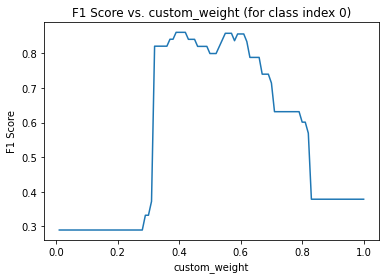

In [96]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 50%/50%, the dataset is balanced. 
- We can see the score performance is quite high at around the vicinity of the a-priori probability/custom_weight = 0.5. 
- Since the class cardinality is already 50%/50%, this is equivalent to the 'equiprobable' version (ie. the 'class weight method').
- The score performance is most optimal at around the vicinity of custom_weight = 0.5, compared to all other custom_weight values to the far left or far right (ie. the score performance is most optimal using the **'weighted'** and/or **'equiprobable'** version).

In [97]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.28986301],
       [0.02      , 0.28986301],
       [0.03      , 0.28986301],
       [0.04      , 0.28986301],
       [0.05      , 0.28986301],
       [0.06      , 0.28986301],
       [0.07      , 0.28986301],
       [0.08      , 0.28986301],
       [0.09      , 0.28986301],
       [0.1       , 0.28986301],
       [0.11      , 0.28986301],
       [0.12      , 0.28986301],
       [0.13      , 0.28986301],
       [0.14      , 0.28986301],
       [0.15      , 0.28986301],
       [0.16      , 0.28986301],
       [0.17      , 0.28986301],
       [0.18      , 0.28986301],
       [0.19      , 0.28986301],
       [0.2       , 0.28986301],
       [0.21      , 0.28986301],
       [0.22      , 0.28986301],
       [0.23      , 0.28986301],
       [0.24      , 0.28986301],
       [0.25      , 0.28986301],
       [0.26      , 0.28986301],
       [0.27      , 0.28986301],
       [0.28      , 0.28986301],
       [0.29      , 0.33246032],
       [0.3       , 0.33246032],
       [0.

In [98]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:85,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [99]:
# Check proportion class imbalance 
# About 40% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.595238
0    0.404762
Name: target, dtype: float64

In [100]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [101]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [102]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=1, n_copies=1, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

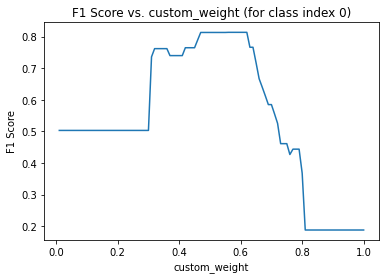

In [103]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 40%/60%, the dataset is still quite balanced. 
- We can see the score performance is already quite high at around the vicinity of the a-priori probability/custom_weight = 0.4. 
- Let's see if we can improve the score performance further by adjusting for the 'equiprobable' version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance only improved a little at around the vicinity of custom_weight = 0.5. This is as expected since the dataset is already quite balanced.
- The score performance is most optimal at around the vicinity of custom_weight = 0.5, compared to all other custom_weight values to the far left or far right (ie. the score performance is most optimal using the **'equiprobable'** version).

In [104]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.50310559],
       [0.02      , 0.50310559],
       [0.03      , 0.50310559],
       [0.04      , 0.50310559],
       [0.05      , 0.50310559],
       [0.06      , 0.50310559],
       [0.07      , 0.50310559],
       [0.08      , 0.50310559],
       [0.09      , 0.50310559],
       [0.1       , 0.50310559],
       [0.11      , 0.50310559],
       [0.12      , 0.50310559],
       [0.13      , 0.50310559],
       [0.14      , 0.50310559],
       [0.15      , 0.50310559],
       [0.16      , 0.50310559],
       [0.17      , 0.50310559],
       [0.18      , 0.50310559],
       [0.19      , 0.50310559],
       [0.2       , 0.50310559],
       [0.21      , 0.50310559],
       [0.22      , 0.50310559],
       [0.23      , 0.50310559],
       [0.24      , 0.50310559],
       [0.25      , 0.50310559],
       [0.26      , 0.50310559],
       [0.27      , 0.50310559],
       [0.28      , 0.50310559],
       [0.29      , 0.50310559],
       [0.3       , 0.50310559],
       [0.

In [105]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:32,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [106]:
# Check proportion class imbalance 
# About 20% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.796178
0    0.203822
Name: target, dtype: float64

In [107]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [108]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [109]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=1, n_copies=1, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

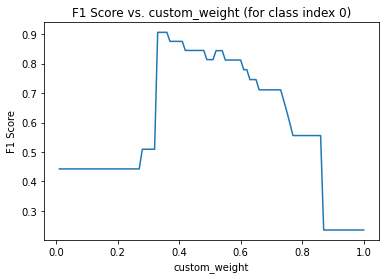

In [110]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 20%/80%, the dataset is imbalanced. 
- We can see the score performance is quite low at around the vicinity of the a-priori probability/custom_weight = 0.2. 
- Let's see if we can improve the score performance by adjusting for the equiprobable version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance improved quite a lot at around the vicinity of custom_weight = 0.5. This is as expected since the dataset is imbalanced.
- The score performance is most optimal at around the vicinity of custom_weight = 0.5, compared to all other custom_weight values to the far left or far right (ie. the score performance is most optimal using the **'equiprobable'** version).

In [111]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.44240196],
       [0.02      , 0.44240196],
       [0.03      , 0.44240196],
       [0.04      , 0.44240196],
       [0.05      , 0.44240196],
       [0.06      , 0.44240196],
       [0.07      , 0.44240196],
       [0.08      , 0.44240196],
       [0.09      , 0.44240196],
       [0.1       , 0.44240196],
       [0.11      , 0.44240196],
       [0.12      , 0.44240196],
       [0.13      , 0.44240196],
       [0.14      , 0.44240196],
       [0.15      , 0.44240196],
       [0.16      , 0.44240196],
       [0.17      , 0.44240196],
       [0.18      , 0.44240196],
       [0.19      , 0.44240196],
       [0.2       , 0.44240196],
       [0.21      , 0.44240196],
       [0.22      , 0.44240196],
       [0.23      , 0.44240196],
       [0.24      , 0.44240196],
       [0.25      , 0.44240196],
       [0.26      , 0.44240196],
       [0.27      , 0.44240196],
       [0.28      , 0.50928571],
       [0.29      , 0.50928571],
       [0.3       , 0.50928571],
       [0.

In [112]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:10,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [113]:
# Check proportion class imbalance
# About 7% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.925926
0    0.074074
Name: target, dtype: float64

In [114]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [115]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [116]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=1, n_copies=1, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

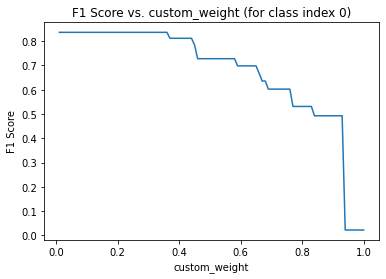

In [117]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 7%/93%, the dataset is highly imbalanced. 
- We can see the score performance is already quite high at around the vicinity of the a-priori probability/custom_weight = 0.07. 
- Let's see if we can improve the score performance further by adjusting for the equiprobable version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance decrease at around the vicinity of custom_weight = 0.5. This could happen because for this dataset, the dataset could be too highly imbalanced that the 'class weight method' does not help in improving the score performance.
- The score performance is most optimal at around the vicinity of custom_weight = 0.07, compared to all other custom_weight values in the middle or far right (ie. the score performance is most optimal using the **'weighted'** version).

In [118]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.83660131],
       [0.02      , 0.83660131],
       [0.03      , 0.83660131],
       [0.04      , 0.83660131],
       [0.05      , 0.83660131],
       [0.06      , 0.83660131],
       [0.07      , 0.83660131],
       [0.08      , 0.83660131],
       [0.09      , 0.83660131],
       [0.1       , 0.83660131],
       [0.11      , 0.83660131],
       [0.12      , 0.83660131],
       [0.13      , 0.83660131],
       [0.14      , 0.83660131],
       [0.15      , 0.83660131],
       [0.16      , 0.83660131],
       [0.17      , 0.83660131],
       [0.18      , 0.83660131],
       [0.19      , 0.83660131],
       [0.2       , 0.83660131],
       [0.21      , 0.83660131],
       [0.22      , 0.83660131],
       [0.23      , 0.83660131],
       [0.24      , 0.83660131],
       [0.25      , 0.83660131],
       [0.26      , 0.83660131],
       [0.27      , 0.83660131],
       [0.28      , 0.83660131],
       [0.29      , 0.83660131],
       [0.3       , 0.83660131],
       [0.

In [119]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:4,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [120]:
# Check proportion class imbalance
# About 3% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.968992
0    0.031008
Name: target, dtype: float64

In [121]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [122]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [123]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=1, n_copies=1, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

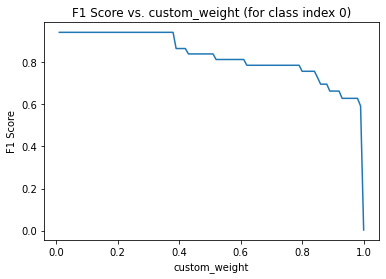

In [124]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 3%/97%, the dataset is highly imbalanced. 
- We can see the score performance is already quite high at around the vicinity of the a-priori probability/custom_weight = 0.03. 
- Let's see if we can improve the score performance further by adjusting for the equiprobable version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance decrease at around the vicinity of custom_weight = 0.5. This could happen because for this dataset, the dataset could be too highly imbalanced that the 'class weight method' does not help in improving the score performance.
- The score performance is most optimal at around the vicinity of custom_weight = 0.03, compared to all other custom_weight values in the middle or far right (ie. the score performance is most optimal using the **'weighted'** version).

In [125]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.94268477],
       [0.02      , 0.94268477],
       [0.03      , 0.94268477],
       [0.04      , 0.94268477],
       [0.05      , 0.94268477],
       [0.06      , 0.94268477],
       [0.07      , 0.94268477],
       [0.08      , 0.94268477],
       [0.09      , 0.94268477],
       [0.1       , 0.94268477],
       [0.11      , 0.94268477],
       [0.12      , 0.94268477],
       [0.13      , 0.94268477],
       [0.14      , 0.94268477],
       [0.15      , 0.94268477],
       [0.16      , 0.94268477],
       [0.17      , 0.94268477],
       [0.18      , 0.94268477],
       [0.19      , 0.94268477],
       [0.2       , 0.94268477],
       [0.21      , 0.94268477],
       [0.22      , 0.94268477],
       [0.23      , 0.94268477],
       [0.24      , 0.94268477],
       [0.25      , 0.94268477],
       [0.26      , 0.94268477],
       [0.27      , 0.94268477],
       [0.28      , 0.94268477],
       [0.29      , 0.94268477],
       [0.3       , 0.94268477],
       [0.

In [138]:
# monk1 dataset (6 features, 556 rows)
import pandas as pd

df = pd.read_csv('monk1.tsv', sep='\t')
X = df.drop('target', axis=1).values
y = df['target'].values

In [139]:
# Check proportion class imbalance
# 50% class index 0
df['target'].value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

In [140]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [141]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [142]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=2, n_copies=2, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

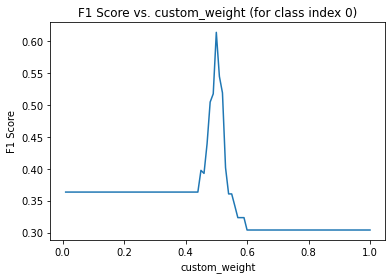

In [143]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 50%/50%, the dataset is balanced. 
- We can see the score performance is high at around the vicinity of the a-priori probability/custom_weight = 0.5. 
- Since the class cardinality is already 50%/50%, this is equivalent to the 'equiprobable' version (ie. the 'class weight method').
- The score performance is most optimal at around the vicinity of custom_weight = 0.5, compared to all other custom_weight values to the far left or far right (ie. the score performance is most optimal using the **'weighted'** and/or **'equiprobable'** version).

In [144]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.36351295],
       [0.02      , 0.36351295],
       [0.03      , 0.36351295],
       [0.04      , 0.36351295],
       [0.05      , 0.36351295],
       [0.06      , 0.36351295],
       [0.07      , 0.36351295],
       [0.08      , 0.36351295],
       [0.09      , 0.36351295],
       [0.1       , 0.36351295],
       [0.11      , 0.36351295],
       [0.12      , 0.36351295],
       [0.13      , 0.36351295],
       [0.14      , 0.36351295],
       [0.15      , 0.36351295],
       [0.16      , 0.36351295],
       [0.17      , 0.36351295],
       [0.18      , 0.36351295],
       [0.19      , 0.36351295],
       [0.2       , 0.36351295],
       [0.21      , 0.36351295],
       [0.22      , 0.36351295],
       [0.23      , 0.36351295],
       [0.24      , 0.36351295],
       [0.25      , 0.36351295],
       [0.26      , 0.36351295],
       [0.27      , 0.36351295],
       [0.28      , 0.36351295],
       [0.29      , 0.36351295],
       [0.3       , 0.36351295],
       [0.

In [149]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:120,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [150]:
# Check proportion class imbalance 
# About 30% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.698492
0    0.301508
Name: target, dtype: float64

In [151]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [152]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [153]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=2, n_copies=2, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

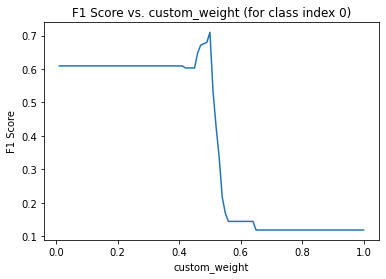

In [154]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 30%/70%, the dataset is imbalanced. 
- We can see the score performance is quite low at around the vicinity of the a-priori probability/custom_weight = 0.3. 
- Let's see if we can improve the score performance by adjusting for the 'equiprobable' version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance improved at around the vicinity of custom_weight = 0.5. This is as expected since the dataset is imbalanced.
- The score performance is most optimal at around the vicinity of custom_weight = 0.5, compared to all other custom_weight values to the far left or far right (ie. the score performance is most optimal using the **'equiprobable'** version).

In [155]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.60942029],
       [0.02      , 0.60942029],
       [0.03      , 0.60942029],
       [0.04      , 0.60942029],
       [0.05      , 0.60942029],
       [0.06      , 0.60942029],
       [0.07      , 0.60942029],
       [0.08      , 0.60942029],
       [0.09      , 0.60942029],
       [0.1       , 0.60942029],
       [0.11      , 0.60942029],
       [0.12      , 0.60942029],
       [0.13      , 0.60942029],
       [0.14      , 0.60942029],
       [0.15      , 0.60942029],
       [0.16      , 0.60942029],
       [0.17      , 0.60942029],
       [0.18      , 0.60942029],
       [0.19      , 0.60942029],
       [0.2       , 0.60942029],
       [0.21      , 0.60942029],
       [0.22      , 0.60942029],
       [0.23      , 0.60942029],
       [0.24      , 0.60942029],
       [0.25      , 0.60942029],
       [0.26      , 0.60942029],
       [0.27      , 0.60942029],
       [0.28      , 0.60942029],
       [0.29      , 0.60942029],
       [0.3       , 0.60942029],
       [0.

In [160]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:50,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [161]:
# Check proportion class imbalance 
# About 15% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.847561
0    0.152439
Name: target, dtype: float64

In [162]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [163]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [164]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=2, n_copies=2, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

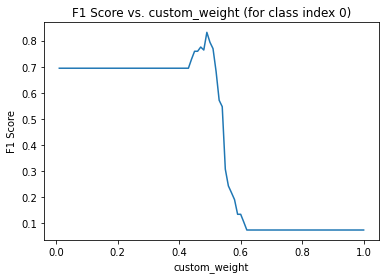

In [165]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 15%/85%, the dataset is imbalanced. 
- We can see the score performance is quite low at around the vicinity of the a-priori probability/custom_weight = 0.15. 
- Let's see if we can improve the score performance by adjusting for the equiprobable version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance improved at around the vicinity of custom_weight = 0.5. This is as expected since the dataset is imbalanced.
- The score performance is most optimal at around the vicinity of custom_weight = 0.5, compared to all other custom_weight values to the far left or far right (ie. the score performance is most optimal using the **'equiprobable'** version).

In [166]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.69440164],
       [0.02      , 0.69440164],
       [0.03      , 0.69440164],
       [0.04      , 0.69440164],
       [0.05      , 0.69440164],
       [0.06      , 0.69440164],
       [0.07      , 0.69440164],
       [0.08      , 0.69440164],
       [0.09      , 0.69440164],
       [0.1       , 0.69440164],
       [0.11      , 0.69440164],
       [0.12      , 0.69440164],
       [0.13      , 0.69440164],
       [0.14      , 0.69440164],
       [0.15      , 0.69440164],
       [0.16      , 0.69440164],
       [0.17      , 0.69440164],
       [0.18      , 0.69440164],
       [0.19      , 0.69440164],
       [0.2       , 0.69440164],
       [0.21      , 0.69440164],
       [0.22      , 0.69440164],
       [0.23      , 0.69440164],
       [0.24      , 0.69440164],
       [0.25      , 0.69440164],
       [0.26      , 0.69440164],
       [0.27      , 0.69440164],
       [0.28      , 0.69440164],
       [0.29      , 0.69440164],
       [0.3       , 0.69440164],
       [0.

In [169]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:15,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [170]:
# Check proportion class imbalance
# About 5% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.948805
0    0.051195
Name: target, dtype: float64

In [171]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [172]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [173]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=2, n_copies=2, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

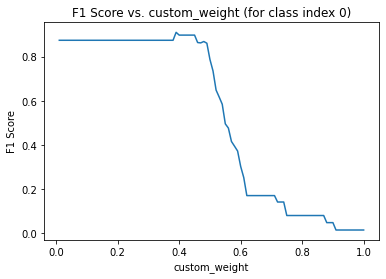

In [174]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 5%/95%, the dataset is highly imbalanced. 
- We can see the score performance is already quite high at around the vicinity of the a-priori probability/custom_weight = 0.05. 
- Let's see if we can improve the score performance further by adjusting for the equiprobable version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance decrease at around the vicinity of custom_weight = 0.5. This could happen because for this dataset, the dataset could be too highly imbalanced that the 'class weight method' does not help in improving the score performance.
- The score performance is most optimal at around the vicinity of custom_weight = 0.05, compared to all other custom_weight values in the middle or far right (ie. the score performance is most optimal using the **'weighted'** version).

In [175]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.87475626],
       [0.02      , 0.87475626],
       [0.03      , 0.87475626],
       [0.04      , 0.87475626],
       [0.05      , 0.87475626],
       [0.06      , 0.87475626],
       [0.07      , 0.87475626],
       [0.08      , 0.87475626],
       [0.09      , 0.87475626],
       [0.1       , 0.87475626],
       [0.11      , 0.87475626],
       [0.12      , 0.87475626],
       [0.13      , 0.87475626],
       [0.14      , 0.87475626],
       [0.15      , 0.87475626],
       [0.16      , 0.87475626],
       [0.17      , 0.87475626],
       [0.18      , 0.87475626],
       [0.19      , 0.87475626],
       [0.2       , 0.87475626],
       [0.21      , 0.87475626],
       [0.22      , 0.87475626],
       [0.23      , 0.87475626],
       [0.24      , 0.87475626],
       [0.25      , 0.87475626],
       [0.26      , 0.87475626],
       [0.27      , 0.87475626],
       [0.28      , 0.87475626],
       [0.29      , 0.87475626],
       [0.3       , 0.87475626],
       [0.

In [180]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:9,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [181]:
# Check proportion class imbalance
# About 3% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.968641
0    0.031359
Name: target, dtype: float64

In [182]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [183]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [184]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=2, n_copies=2, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

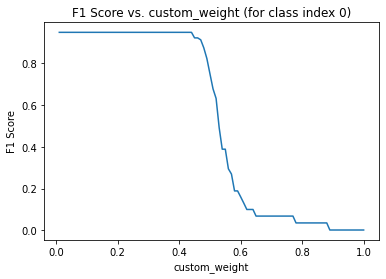

In [185]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 3%/97%, the dataset is highly imbalanced. 
- We can see the score performance is already quite high at around the vicinity of the a-priori probability/custom_weight = 0.03. 
- Let's see if we can improve the score performance further by adjusting for the equiprobable version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance decrease at around the vicinity of custom_weight = 0.5. This could happen because for this dataset, the dataset could be too highly imbalanced that the 'class weight method' does not help in improving the score performance.
- The score performance is most optimal at around the vicinity of custom_weight = 0.03, compared to all other custom_weight values in the middle or far right (ie. the score performance is most optimal using the **'weighted'** version).

In [186]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.94857834],
       [0.02      , 0.94857834],
       [0.03      , 0.94857834],
       [0.04      , 0.94857834],
       [0.05      , 0.94857834],
       [0.06      , 0.94857834],
       [0.07      , 0.94857834],
       [0.08      , 0.94857834],
       [0.09      , 0.94857834],
       [0.1       , 0.94857834],
       [0.11      , 0.94857834],
       [0.12      , 0.94857834],
       [0.13      , 0.94857834],
       [0.14      , 0.94857834],
       [0.15      , 0.94857834],
       [0.16      , 0.94857834],
       [0.17      , 0.94857834],
       [0.18      , 0.94857834],
       [0.19      , 0.94857834],
       [0.2       , 0.94857834],
       [0.21      , 0.94857834],
       [0.22      , 0.94857834],
       [0.23      , 0.94857834],
       [0.24      , 0.94857834],
       [0.25      , 0.94857834],
       [0.26      , 0.94857834],
       [0.27      , 0.94857834],
       [0.28      , 0.94857834],
       [0.29      , 0.94857834],
       [0.3       , 0.94857834],
       [0.

In [197]:
# bupa dataset (5 features, 345 rows)
import pandas as pd

df = pd.read_csv('bupa.tsv', sep='\t')
X = df.drop('target', axis=1).values
y = df['target'].values

In [198]:
# Check proportion class imbalance
# About 50% class index 0
df['target'].value_counts(normalize=True)

1    0.510145
0    0.489855
Name: target, dtype: float64

In [199]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [200]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [201]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=0.5, n_copies=3, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

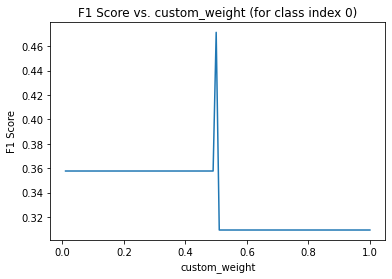

In [202]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 50%/50%, the dataset is balanced. 
- We can see the score performance is high at around the vicinity of the a-priori probability/custom_weight = 0.5. 
- Since the class cardinality is already 50%/50%, this is equivalent to the 'equiprobable' version (ie. the 'class weight method').
- The score performance is most optimal at around the vicinity of custom_weight = 0.5, compared to all other custom_weight values to the far left or far right (ie. the score performance is most optimal using the **'weighted'** and/or **'equiprobable'** version).

In [203]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.35776398],
       [0.02      , 0.35776398],
       [0.03      , 0.35776398],
       [0.04      , 0.35776398],
       [0.05      , 0.35776398],
       [0.06      , 0.35776398],
       [0.07      , 0.35776398],
       [0.08      , 0.35776398],
       [0.09      , 0.35776398],
       [0.1       , 0.35776398],
       [0.11      , 0.35776398],
       [0.12      , 0.35776398],
       [0.13      , 0.35776398],
       [0.14      , 0.35776398],
       [0.15      , 0.35776398],
       [0.16      , 0.35776398],
       [0.17      , 0.35776398],
       [0.18      , 0.35776398],
       [0.19      , 0.35776398],
       [0.2       , 0.35776398],
       [0.21      , 0.35776398],
       [0.22      , 0.35776398],
       [0.23      , 0.35776398],
       [0.24      , 0.35776398],
       [0.25      , 0.35776398],
       [0.26      , 0.35776398],
       [0.27      , 0.35776398],
       [0.28      , 0.35776398],
       [0.29      , 0.35776398],
       [0.3       , 0.35776398],
       [0.

In [204]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:60,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [205]:
# Check proportion class imbalance 
# About 25% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.745763
0    0.254237
Name: target, dtype: float64

In [206]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [207]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [208]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=0.5, n_copies=3, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

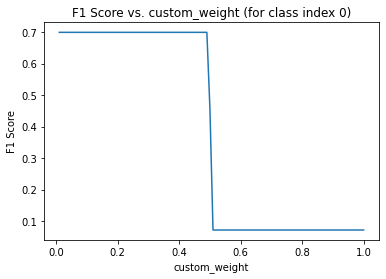

In [209]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 25%/75%, the dataset is imbalanced. 
- We can see the score performance is quite low at around the vicinity of the a-priori probability/custom_weight = 0.25. 
- Let's see if we can improve the score performance further by adjusting for the 'equiprobable' version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance decreased at around the vicinity of custom_weight = 0.5. This could happen because for this dataset, the dataset could be too highly imbalanced that the 'class weight method' does not help in improving the score performance.
- The score performance is most optimal at around the vicinity of custom_weight = 0.25, compared to all other custom_weight values in the middle or far right (ie. the score performance is most optimal using the **'weighted'** version).

In [210]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.6996124 ],
       [0.02      , 0.6996124 ],
       [0.03      , 0.6996124 ],
       [0.04      , 0.6996124 ],
       [0.05      , 0.6996124 ],
       [0.06      , 0.6996124 ],
       [0.07      , 0.6996124 ],
       [0.08      , 0.6996124 ],
       [0.09      , 0.6996124 ],
       [0.1       , 0.6996124 ],
       [0.11      , 0.6996124 ],
       [0.12      , 0.6996124 ],
       [0.13      , 0.6996124 ],
       [0.14      , 0.6996124 ],
       [0.15      , 0.6996124 ],
       [0.16      , 0.6996124 ],
       [0.17      , 0.6996124 ],
       [0.18      , 0.6996124 ],
       [0.19      , 0.6996124 ],
       [0.2       , 0.6996124 ],
       [0.21      , 0.6996124 ],
       [0.22      , 0.6996124 ],
       [0.23      , 0.6996124 ],
       [0.24      , 0.6996124 ],
       [0.25      , 0.6996124 ],
       [0.26      , 0.6996124 ],
       [0.27      , 0.6996124 ],
       [0.28      , 0.6996124 ],
       [0.29      , 0.6996124 ],
       [0.3       , 0.6996124 ],
       [0.

In [211]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:20,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [212]:
# Check proportion class imbalance 
# About 10% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.897959
0    0.102041
Name: target, dtype: float64

In [213]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [214]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [215]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=0.5, n_copies=3, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

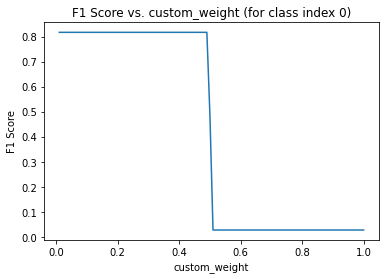

In [216]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 10%/90%, the dataset is imbalanced. 
- We can see the score performance is quite low at around the vicinity of the a-priori probability/custom_weight = 0.1. 
- Let's see if we can improve the score performance further by adjusting for the 'equiprobable' version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance decreased at around the vicinity of custom_weight = 0.5. This could happen because for this dataset, the dataset could be too highly imbalanced that the 'class weight method' does not help in improving the score performance.
- The score performance is most optimal at around the vicinity of custom_weight = 0.1, compared to all other custom_weight values in the middle or far right (ie. the score performance is most optimal using the **'weighted'** version).

In [217]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.81666667],
       [0.02      , 0.81666667],
       [0.03      , 0.81666667],
       [0.04      , 0.81666667],
       [0.05      , 0.81666667],
       [0.06      , 0.81666667],
       [0.07      , 0.81666667],
       [0.08      , 0.81666667],
       [0.09      , 0.81666667],
       [0.1       , 0.81666667],
       [0.11      , 0.81666667],
       [0.12      , 0.81666667],
       [0.13      , 0.81666667],
       [0.14      , 0.81666667],
       [0.15      , 0.81666667],
       [0.16      , 0.81666667],
       [0.17      , 0.81666667],
       [0.18      , 0.81666667],
       [0.19      , 0.81666667],
       [0.2       , 0.81666667],
       [0.21      , 0.81666667],
       [0.22      , 0.81666667],
       [0.23      , 0.81666667],
       [0.24      , 0.81666667],
       [0.25      , 0.81666667],
       [0.26      , 0.81666667],
       [0.27      , 0.81666667],
       [0.28      , 0.81666667],
       [0.29      , 0.81666667],
       [0.3       , 0.81666667],
       [0.

In [218]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:10,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [219]:
# Check proportion class imbalance
# About 5% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.946237
0    0.053763
Name: target, dtype: float64

In [220]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [221]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [222]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=0.5, n_copies=3, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

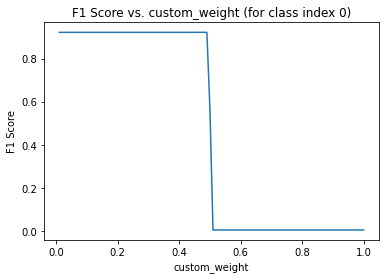

In [223]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 5%/95%, the dataset is highly imbalanced. 
- We can see the score performance is quite high at around the vicinity of the a-priori probability/custom_weight = 0.05. 
- Let's see if we can improve the score performance further by adjusting for the 'equiprobable' version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance decreased at around the vicinity of custom_weight = 0.5. This could happen because for this dataset, the dataset could be too highly imbalanced that the 'class weight method' does not help in improving the score performance.
- The score performance is most optimal at around the vicinity of custom_weight = 0.05, compared to all other custom_weight values in the middle or far right (ie. the score performance is most optimal using the **'weighted'** version).

In [224]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.92176387],
       [0.02      , 0.92176387],
       [0.03      , 0.92176387],
       [0.04      , 0.92176387],
       [0.05      , 0.92176387],
       [0.06      , 0.92176387],
       [0.07      , 0.92176387],
       [0.08      , 0.92176387],
       [0.09      , 0.92176387],
       [0.1       , 0.92176387],
       [0.11      , 0.92176387],
       [0.12      , 0.92176387],
       [0.13      , 0.92176387],
       [0.14      , 0.92176387],
       [0.15      , 0.92176387],
       [0.16      , 0.92176387],
       [0.17      , 0.92176387],
       [0.18      , 0.92176387],
       [0.19      , 0.92176387],
       [0.2       , 0.92176387],
       [0.21      , 0.92176387],
       [0.22      , 0.92176387],
       [0.23      , 0.92176387],
       [0.24      , 0.92176387],
       [0.25      , 0.92176387],
       [0.26      , 0.92176387],
       [0.27      , 0.92176387],
       [0.28      , 0.92176387],
       [0.29      , 0.92176387],
       [0.3       , 0.92176387],
       [0.

In [231]:
# Create imbalanced dataset by removing rows from target=0
df0 = df[df['target']==0]
df0_keep = df0.iloc[:4,:]

df1 = df[df['target']==1]

df_imbalanced = pd.concat([df0_keep, df1], axis=0)
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values

In [232]:
# Check proportion class imbalance
# About 2% class index 0
df_imbalanced['target'].value_counts(normalize=True)

1    0.977778
0    0.022222
Name: target, dtype: float64

In [233]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

In [234]:
import numpy as np
# Create custom_weight (for class index 0) hyperparamter list [0.01, 0.02,...,1.0]
custom_weight_list = np.linspace(0.01, 1.0, 100).tolist()

In [235]:
from sklearn import metrics

f1_sc = []
for i, wgt in enumerate(custom_weight_list):
    # Obtain F1 score for various custom_weight (for class index 0) values
    model = PGMHQC_gpu_dtype(rescale=0.5, n_copies=3, encoding='stereo', measure='hels', class_wgt='custom', custom_weight=wgt, n_splits=1, dtype=torch.float64).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    f1_sc.append(metrics.f1_score(y_test, y_hat, average='weighted'))

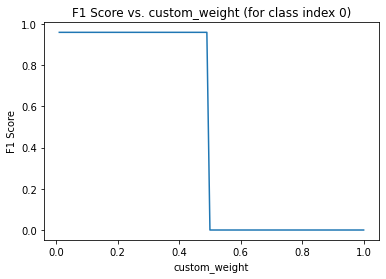

In [236]:
import matplotlib.pyplot as plt

# Plot F1 score vs. custom_weight (for class index 0) values
plt.plot(custom_weight_list, f1_sc)
plt.xlabel('custom_weight')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. custom_weight (for class index 0)')
plt.show()

**Commentary:** 
- Since the class cardinality is 2%/98%, the dataset is highly imbalanced. 
- We can see the score performance is quite high at around the vicinity of the a-priori probability/custom_weight = 0.02. 
- Let's see if we can improve the score performance further by adjusting for the 'equiprobable' version (ie. adjusting for the 'class weight method'). After adjusting for this, the score performance decreased at around the vicinity of custom_weight = 0.5. This could happen because for this dataset, the dataset could be too highly imbalanced that the 'class weight method' does not help in improving the score performance.
- The score performance is most optimal at around the vicinity of custom_weight = 0.02, compared to all other custom_weight values in the middle or far right (ie. the score performance is most optimal using the **'weighted'** version).

In [237]:
np.concatenate([np.array(custom_weight_list).reshape(-1,1), np.array(f1_sc).reshape(-1,1)], axis=1)

array([[0.01      , 0.95852895],
       [0.02      , 0.95852895],
       [0.03      , 0.95852895],
       [0.04      , 0.95852895],
       [0.05      , 0.95852895],
       [0.06      , 0.95852895],
       [0.07      , 0.95852895],
       [0.08      , 0.95852895],
       [0.09      , 0.95852895],
       [0.1       , 0.95852895],
       [0.11      , 0.95852895],
       [0.12      , 0.95852895],
       [0.13      , 0.95852895],
       [0.14      , 0.95852895],
       [0.15      , 0.95852895],
       [0.16      , 0.95852895],
       [0.17      , 0.95852895],
       [0.18      , 0.95852895],
       [0.19      , 0.95852895],
       [0.2       , 0.95852895],
       [0.21      , 0.95852895],
       [0.22      , 0.95852895],
       [0.23      , 0.95852895],
       [0.24      , 0.95852895],
       [0.25      , 0.95852895],
       [0.26      , 0.95852895],
       [0.27      , 0.95852895],
       [0.28      , 0.95852895],
       [0.29      , 0.95852895],
       [0.3       , 0.95852895],
       [0.